<a href="https://colab.research.google.com/github/CINDYSLUO/luo-essay-scoring/blob/main/cindy_ml_final_project_essay_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Standard library imports
import csv
import io
import random
import joblib
from joblib import dump, load
import pickle

# Third-party library imports for data handling
import pandas as pd
import numpy as np
import re
!pip install textstat
import textstat

# Natural Language Processing with NLTK
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

# Machine Learning and Data Science imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import xgboost as xgb

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Gensim for topic modeling
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

# TensorFlow/Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Hugging Face Transformers for pre-trained language models
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import AutoModel, AutoTokenizer

# Set stopwords and download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
STOPWORDS = set(stopwords.words('english'))

# Set seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/APIA_Essays_Demographic_Data.csv'

df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/"

 APIA_Essays.csv		    bi_lstm_model.keras   distilbert_tokenizer	 Miscellaneous
 APIA_Essays_Demographic_Data.csv  'Career Materials'	 'Georgetown MLC'
'APIA Scholars'			   'Colab Notebooks'	  glove.6B.100d.txt
 bi_lstm_model.h5		    distilbert_model	  lstm_model.h5


In [ ]:
# Begin with initial data inspection

# Display the first few rows of the dataframe
df.head()


,Status,Gender,Region,AANHPI_Ethnicity,AA_Ethnicity,Specific_AA_Ethnicity,NHPI_Ethnicity,Specific_NHPI_Ethnicity,Asian_Sub-Ethnicity,Siblings_College,...,AvgScoreAcrossReviewers,TotalScoreNoFinScore,TotalScore,Essay1Option,Essay1,Essay2Option,Essay2,Option3,Essay3Option,Essay3
0,Preliminary Finalist,Woman,Midwest,Yes,Yes,"[""Chinese""]",No,NaN,East Asian,Yes,...,38.5,41.0,51.0,Option 1,"In my junior year of high school, I joined the...",Option 2,I’ve been aware of my Chinese American identit...,Write 3rd Essay Response,Option 4,"Growing up in a low-income household, my paren..."
1,Preliminary Finalist,Woman,Pacific,Yes,No,NaN,Yes,"[""Something Else"", ""Kosraean""]",NaN,Yes,...,27.5,32.0,42.0,Option 3,"To me, my interpretation of success would be t...",Option 2,“Tomorrow is going to be a beautiful day” I m...,Request a Recommendation Letter,My recommender submitted before the deadline date,NaN
2,Preliminary Finalist,Man,Northeast,Yes,Yes,"[""Chinese""]",No,NaN,East Asian,No,...,26.5,30.5,40.5,Option 2,Expectations is one of the biggest factors whe...,Option 3,I define success as being financially stable. ...,Write 3rd Essay Response,Option 4,Community is a place that shouldn’t have the n...
3,Preliminary Finalist,Man,South,Yes,Yes,"[""Burmese""]",No,NaN,Southeast Asian,No,...,32.0,36.0,46.0,Option 3,Defining Success and Aspiring Towards It\n\nSu...,Option 4,Community: The Heart of Connection and Support...,Request a Recommendation Letter,NaN,NaN
4,Preliminary Finalist,Woman,Midwest,Yes,Yes,"[""Tibetan""]",No,NaN,Other Asian,Yes,...,32.0,32.0,37.0,Option 1,"In the fall of 2023, I had the honor of partic...",Option 2,As a Tibetan American within the broader Asian...,Request a Recommendation Letter,My recommender submitted before the deadline date,NaN


In [ ]:
# Display the last few rows of the dataframe
df.tail()


,Status,Gender,Region,AANHPI_Ethnicity,AA_Ethnicity,Specific_AA_Ethnicity,NHPI_Ethnicity,Specific_NHPI_Ethnicity,Asian_Sub-Ethnicity,Siblings_College,...,AvgScoreAcrossReviewers,TotalScoreNoFinScore,TotalScore,Essay1Option,Essay1,Essay2Option,Essay2,Option3,Essay3Option,Essay3
4601,Not Selected,Man,South,Yes,Yes,"[""Vietnamese""]",No,NaN,Southeast Asian,No,...,18.5,20.0,26.0,Option 1,"There laid in the mundanity, in the push—both ...",Option 2,Teachers and other students’ voices compile in...,Write 3rd Essay Response,Option 4,The Asian American community represents a rich...
4602,Not Selected,Man,West,Yes,Yes,"[""Japanese"", ""Something Else""]",Yes,"[""Samoan"", ""Yapese""]",East Asian,No,...,18.5,22.0,32.0,Option 4,Community provides one with a sense of belongi...,Option 3,Success is a state of fluidity in which a pers...,Write 3rd Essay Response,Option 1,"From a time in college this last quarter, I wa..."
4603,Not Selected,Woman,South,Yes,Yes,"[""Bangladeshi""]",No,NaN,South Asian,No,...,22.5,22.5,26.5,Option 4,The Muslim community has been a key part of my...,Option 2,The ideology of Sadaqah– the act of voluntary ...,Write 3rd Essay Response,Option 1,I’ve spent my life with “my eyes on the prize”...
4604,Not Selected,Man,West,Yes,Yes,"[""Indian""]",No,NaN,South Asian,No,...,2.0,3.5,12.5,Option 2,Taking on a leadership role in a college group...,Option 4,Title: Building a Stronger Community: Embracin...,Write 3rd Essay Response,Option 2,Being Asian American can significantly impact ...
4605,Not Selected,Man,West,Yes,Yes,"[""Chinese""]",No,NaN,East Asian,Yes,...,26.5,28.0,32.0,Option 2,Though Southern California is as multicultural...,Option 1,"I swung my mouse, sending my character around ...",Write 3rd Essay Response,Option 4,"“Can you guys hear me?” I asked, waving at my ..."


In [ ]:
# Get a concise summary of the dataframe, including the number of non-null values in each column
df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4606 entries, 0 to 4605
Data columns (total 52 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Status                                 4606 non-null   object 
 1   Gender                                 4606 non-null   object 
 2   Region                                 4606 non-null   object 
 3   AANHPI_Ethnicity                       4606 non-null   object 
 4   AA_Ethnicity                           4606 non-null   object 
 5   Specific_AA_Ethnicity                  4260 non-null   object 
 6   NHPI_Ethnicity                         4606 non-null   object 
 7   Specific_NHPI_Ethnicity                727 non-null    object 
 8   Asian_Sub-Ethnicity                    4265 non-null   object 
 9   Siblings_College                       4606 non-null   object 
 10  Parent1_Edu                            4606 non-null   object 
 11  Pare

Status                                      0
Gender                                      0
Region                                      0
AANHPI_Ethnicity                            0
AA_Ethnicity                                0
Specific_AA_Ethnicity                     346
NHPI_Ethnicity                              0
Specific_NHPI_Ethnicity                  3879
Asian_Sub-Ethnicity                       341
Siblings_College                            0
Parent1_Edu                                 0
Parent2_Edu                                15
First-Gen                                   0
First-In-Family                             0
Current_School_Year                         0
GPA_converted                               0
Participation_College_Access_Programs       0
Enrolled_Undergrad_Student                  0
Institution_Type                            0
Type_of_funded_institution                  0
AANAPISI                                 3196
Area_of_Study                     

In [ ]:
# Filter out 'Essay3' rows that contain specific text indicating a recommender letter
essays_df = df[~df['Essay3'].str.contains("My recommender submitted", na=False)]

In [ ]:
# Data Cleaning, fill in 0's/no's/none's, etc. for missing values

df['Specific_AA_Ethnicity'].fillna('none', inplace=True)
df['Specific_NHPI_Ethnicity'].fillna('none', inplace=True)
df['Asian_Sub-Ethnicity'].fillna('NHPI', inplace=True)
df['Parent2_Edu'].fillna('Unknown', inplace=True)
df['AANAPISI'].fillna('no', inplace=True)
df['FirstGen_Score'].fillna(0, inplace=True)
df['NHPI_Score'].fillna(0, inplace=True)
df['Gender_Score'].fillna(0, inplace=True)
df['Essay3Option'].fillna('My recommender submitted before the deadline date', inplace=True)
df['Essay3'].fillna('none', inplace=True)

In [ ]:
# Create combined columns that will store all essays and their corresponding scores. Each essay will be treated as a separate observation.
# Initialize lists to store essays and scores (long format data frame)

# Define additional features to include beyond essays and their scores
additional_features = [
    'Gross_Income_2022', 'Household_Family_Members', 'Poverty_Guidelines', 'Gender',
    'Region', 'Specific_AA_Ethnicity', 'Specific_NHPI_Ethnicity', 'Siblings_College',
    'Parent1_Edu', 'Parent2_Edu','First-Gen', 'First-In-Family', 'Current_School_Year',
    'Participation_College_Access_Programs', 'Enrolled_Undergrad_Student',
    'Institution_Type', 'Type_of_funded_institution', 'AANAPISI', 'Area_of_Study',
    'Financially_Independent'
]

# Initialize lists to store essays, scores, and additional features
all_essays = []
all_scores = []
feature_lists = {feature: [] for feature in additional_features}  # Create a list for each feature

# Append data from each essay and its score
columns = [(1, '1stEssayScore1', '1stEssayScore2'),
           (2, '2ndEssayScore1', '2ndEssayScore2'),
           (3, '3rdEssayorRecScore1', '3rdEssayorRecScore2')]

for i, score1, score2 in columns:
    # Check for essays that are not empty
    valid_essays = essays_df[f'Essay{i}'].notna()

    # Add essays to the list
    all_essays.extend(essays_df.loc[valid_essays, f'Essay{i}'].tolist())

    # Calculate average scores and add to the list
    all_scores.extend(((essays_df.loc[valid_essays, score1] + df.loc[valid_essays, score2]) / 2).tolist())

    # Add additional features
    for feature in additional_features:
        feature_lists[feature].extend(df.loc[valid_essays, feature].tolist())

# Create a new DataFrame with essays, scores, and additional features
combined_df = pd.DataFrame({
    'Essay': all_essays,
    'Score': all_scores,
    **{feature: feature_lists[feature] for feature in additional_features}  # Unpack each list into the DataFrame
})

print(combined_df.head())
print(combined_df.info())

                                               Essay  Score  \
0  In my junior year of high school, I joined the...    9.5   
1  To me, my interpretation of success would be t...    7.0   
2  Expectations is one of the biggest factors whe...    7.5   
3  Defining Success and Aspiring Towards It\n\nSu...    7.5   
4  In the fall of 2023, I had the honor of partic...    8.0   

   Gross_Income_2022  Household_Family_Members  Poverty_Guidelines Gender  \
0            28436.0                         4               31200  Woman   
1                0.0                         6               48260  Woman   
2            41408.0                         6               41960    Man   
3            25000.0                         4               31200    Man   
4           131179.0                         6               41960  Woman   

      Region Specific_AA_Ethnicity         Specific_NHPI_Ethnicity  \
0    Midwest           ["Chinese"]                            none   
1    Pacific      

In [ ]:
# Define a function to clean the text data

def clean_text(text):
    # Function to clean text data
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = re.sub("\s+", " ", text).strip()
    return text

# Apply text cleaning
combined_df['Essay'] = combined_df['Essay'].apply(clean_text)

In [ ]:
# Dropping rows with missing scores if there are any
combined_df = combined_df.dropna(subset=['Score'])

# Save the clean data for further analysis
combined_df.to_csv('Cleaned_Combined_Essays.csv', index=False)

In [ ]:
# Let's perform some basic exploratory data analysis.
# Display basic statistics to understand the distribution of scores.
combined_df.describe()

,Score,Gross_Income_2022,Household_Family_Members,Poverty_Guidelines
count,12574.000000,1.257400e+04,12574.000000,12574.000000
mean,6.827183,8.913552e+04,4.186337,32942.180690
std,1.699708,1.459291e+06,1.655688,9389.063494
min,0.000000,0.000000e+00,1.000000,15060.000000
25%,6.000000,2.700000e+04,3.000000,25820.000000
50%,7.000000,5.155500e+04,4.000000,31200.000000
75%,8.000000,9.154800e+04,5.000000,36580.000000
max,10.000000,9.414800e+07,15.000000,103970.000000


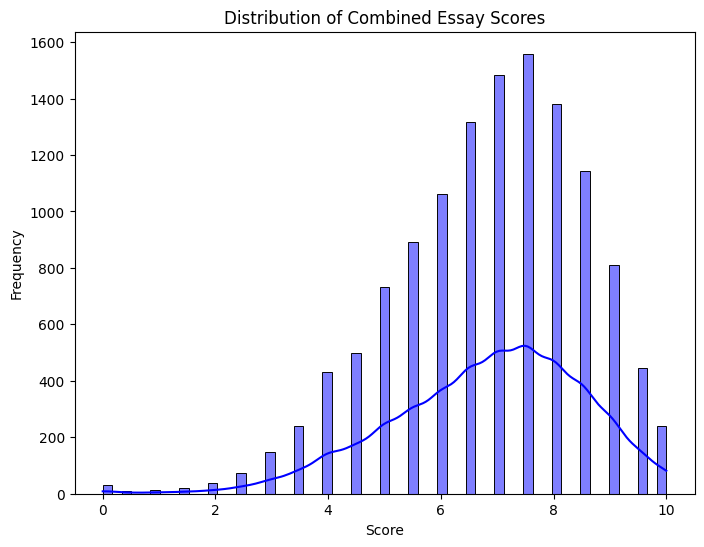

In [ ]:
# Distribution of scores: Visualize the distribution of essay scores to see if they are skewed, normal, or have outliers.

# Assuming 'combined_df' is the name of your DataFrame that has the combined essays and scores
# Plotting histogram of the combined scores
plt.figure(figsize=(8, 6))  # Adjusted figure size for one plot
sns.histplot(combined_df['Score'], kde=True, color='blue')  # You can change the color if you prefer something else
plt.title('Distribution of Combined Essay Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

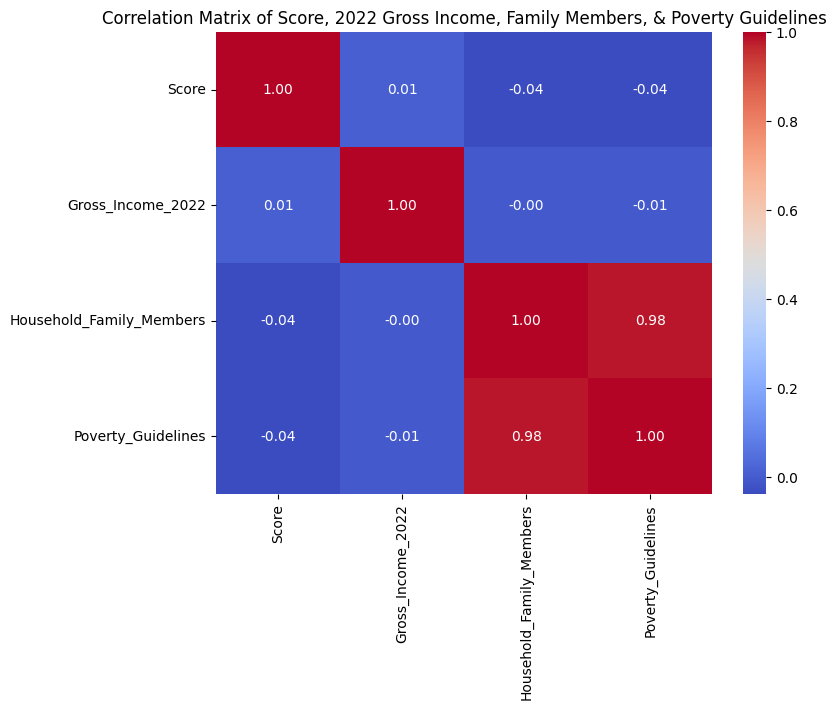

In [ ]:
# Calculate the correlation matrix
corr = combined_df[['Score', 'Gross_Income_2022', 'Household_Family_Members', 'Poverty_Guidelines']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Score, 2022 Gross Income, Family Members, & Poverty Guidelines')
plt.show()

In [ ]:
# Let's add two interaction features
combined_df['Family_Poverty_Interaction'] = combined_df['Household_Family_Members'] * combined_df['Poverty_Guidelines']
combined_df['Income_Poverty_Interaction'] = combined_df['Gross_Income_2022'] * combined_df['Poverty_Guidelines']

In [ ]:
# Text Analysis - let's add additional features

# Calculate essay length (number of words)
combined_df['Length'] = combined_df['Essay'].apply(lambda x: len(x.split()))

# Calculate Flesch Reading Ease score for each essay
combined_df['FleschReadingEase'] = combined_df['Essay'].apply(textstat.flesch_reading_ease)

# Calculate the average length of words in an essay
combined_df['AvgWordLength'] = combined_df['Essay'].apply(lambda x: np.mean([len(word) for word in x.split()]))

# Calculate Type-Token Ratio, the number of unique words divided by total number of words
combined_df['TypeTokenRatio'] = combined_df['Essay'].apply(lambda x: len(set(x.split())) / len(x.split()))


In [ ]:
print(combined_df.columns)

Index(['Essay', 'Score', 'Gross_Income_2022', 'Household_Family_Members',
       'Poverty_Guidelines', 'Gender', 'Region', 'Specific_AA_Ethnicity',
       'Specific_NHPI_Ethnicity', 'Siblings_College', 'Parent1_Edu',
       'Parent2_Edu', 'First-Gen', 'First-In-Family', 'Current_School_Year',
       'Participation_College_Access_Programs', 'Enrolled_Undergrad_Student',
       'Institution_Type', 'Type_of_funded_institution', 'AANAPISI',
       'Area_of_Study', 'Financially_Independent',
       'Family_Poverty_Interaction', 'Income_Poverty_Interaction', 'Length',
       'FleschReadingEase', 'AvgWordLength', 'TypeTokenRatio'],
      dtype='object')


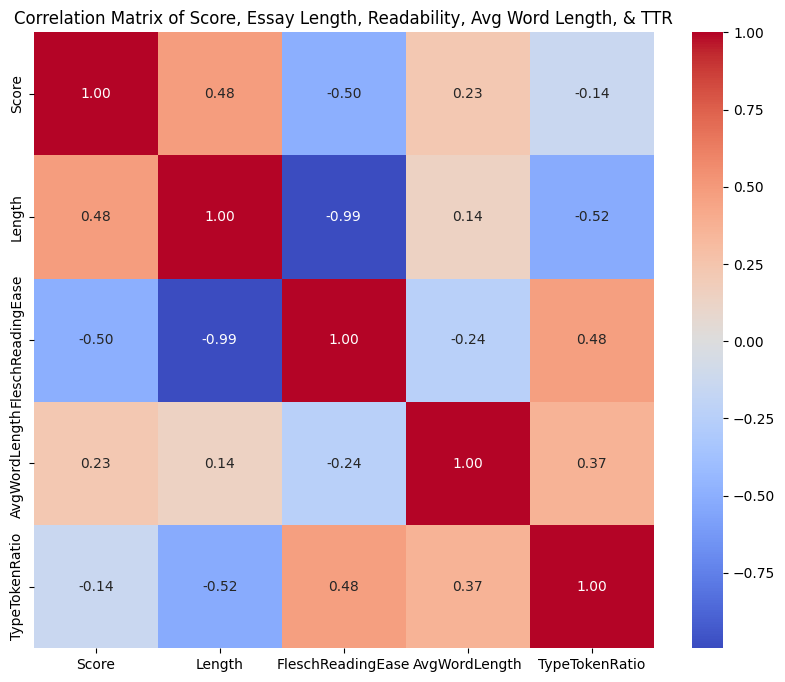

In [ ]:
# Calculate the correlation matrix
corr = combined_df[['Score', 'Length', 'FleschReadingEase', 'AvgWordLength', 'TypeTokenRatio']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Score, Essay Length, Readability, Avg Word Length, & TTR')
plt.show()

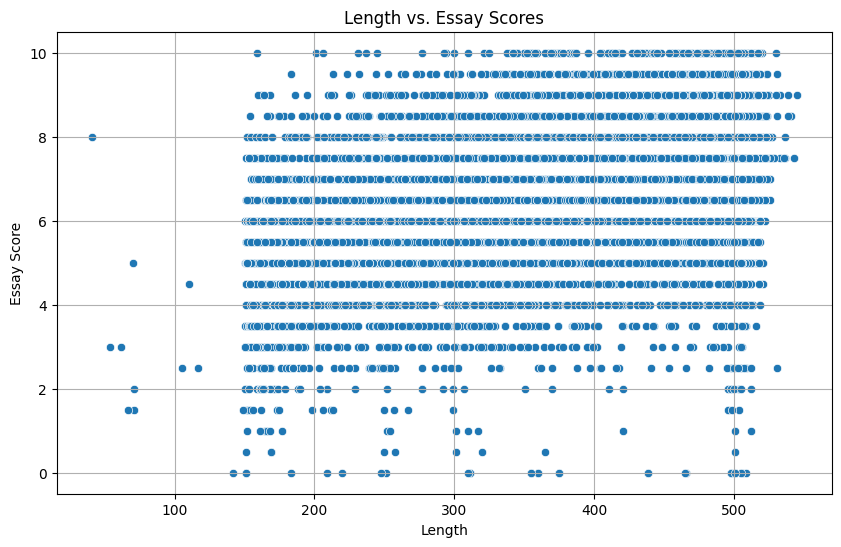

In [ ]:
# Plotting essay length against essay scores for visual analysis

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Length', y='Score', data=combined_df)
plt.title('Length vs. Essay Scores')
plt.xlabel('Length')
plt.ylabel('Essay Score')
plt.grid(True)  # Adds a grid for easier readability
plt.show()

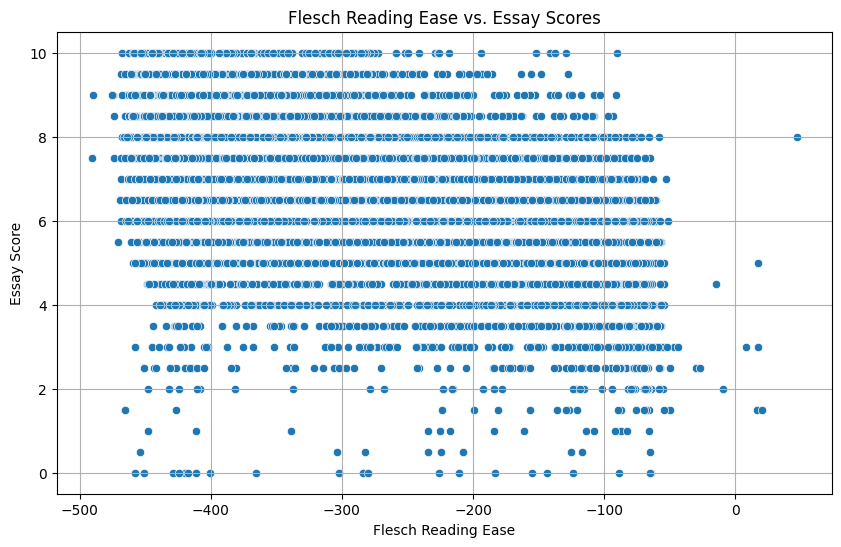

In [ ]:
# Plotting Flesch scores against essay scores for visual analysis

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='FleschReadingEase', y='Score', data=combined_df)
plt.title('Flesch Reading Ease vs. Essay Scores')
plt.xlabel('Flesch Reading Ease')
plt.ylabel('Essay Score')
plt.grid(True)  # Adds a grid for easier readability
plt.show()

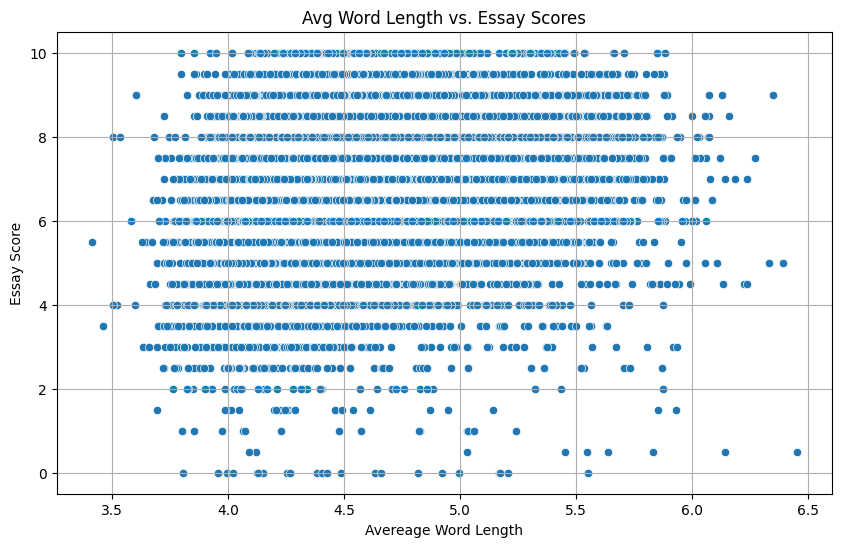

In [ ]:
# Plotting type token ratio against essay scores for visual analysis

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AvgWordLength', y='Score', data=combined_df)
plt.title('Avg Word Length vs. Essay Scores')
plt.xlabel('Avereage Word Length')
plt.ylabel('Essay Score')
plt.grid(True)  # Adds a grid for easier readability
plt.show()

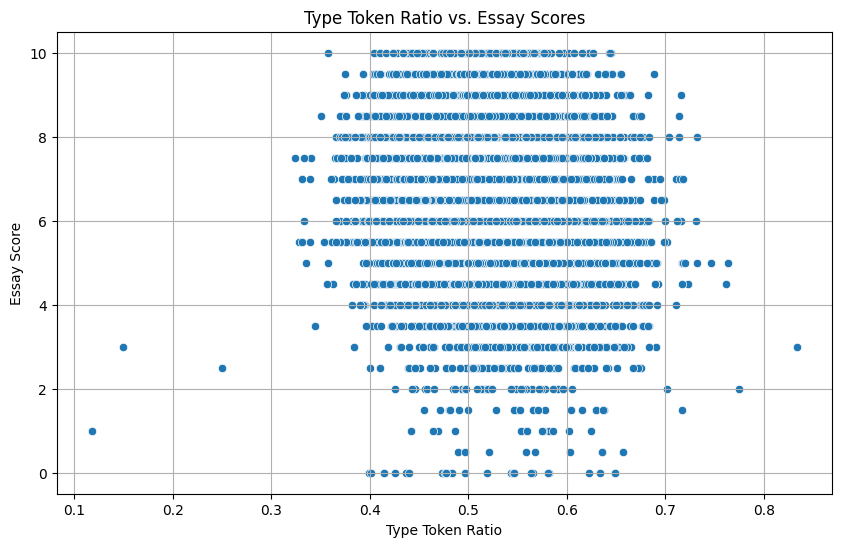

In [ ]:
# Plotting type token ratio against essay scores for visual analysis

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TypeTokenRatio', y='Score', data=combined_df)
plt.title('Type Token Ratio vs. Essay Scores')
plt.xlabel('Type Token Ratio')
plt.ylabel('Essay Score')
plt.grid(True)  # Adds a grid for easier readability
plt.show()

In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12574 entries, 0 to 12573
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Essay                                  12574 non-null  object 
 1   Score                                  12574 non-null  float64
 2   Gross_Income_2022                      12574 non-null  float64
 3   Household_Family_Members               12574 non-null  int64  
 4   Poverty_Guidelines                     12574 non-null  int64  
 5   Gender                                 12574 non-null  object 
 6   Region                                 12574 non-null  object 
 7   Specific_AA_Ethnicity                  12574 non-null  object 
 8   Specific_NHPI_Ethnicity                12574 non-null  object 
 9   Siblings_College                       12574 non-null  object 
 10  Parent1_Edu                            12574 non-null  object 
 11  Pa

In [ ]:
# Now that we've added a few text complexity features, let's focus on adding some syntactic complexity features.

# Calculate the sentence length variability (which can be indicative of more complex features)
def average_sentence_length(text):
    sentences = sent_tokenize(text)
    return np.mean([len(word_tokenize(sentence)) for sentence in sentences])

combined_df['AvgSentenceLength'] = combined_df['Essay'].apply(average_sentence_length)

# Calculate a sentiment score, which may relate to essay content and effectiveness
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
combined_df['SentimentScore'] = combined_df['Essay'].apply(lambda x: sia.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Readability scores beyond Flesch: Gunning Fog Index & Coleman-Liau Index (may provide additional insights into text complexity)
combined_df['GunningFog'] = combined_df['Essay'].apply(textstat.gunning_fog)
combined_df['ColemanLiauIndex'] = combined_df['Essay'].apply(textstat.coleman_liau_index)

In [ ]:
combined_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12574 entries, 0 to 12573
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Essay                                  12574 non-null  object 
 1   Score                                  12574 non-null  float64
 2   Gross_Income_2022                      12574 non-null  float64
 3   Household_Family_Members               12574 non-null  int64  
 4   Poverty_Guidelines                     12574 non-null  int64  
 5   Gender                                 12574 non-null  object 
 6   Region                                 12574 non-null  object 
 7   Specific_AA_Ethnicity                  12574 non-null  object 
 8   Specific_NHPI_Ethnicity                12574 non-null  object 
 9   Siblings_College                       12574 non-null  object 
 10  Parent1_Edu                            12574 non-null  object 
 11  Pa

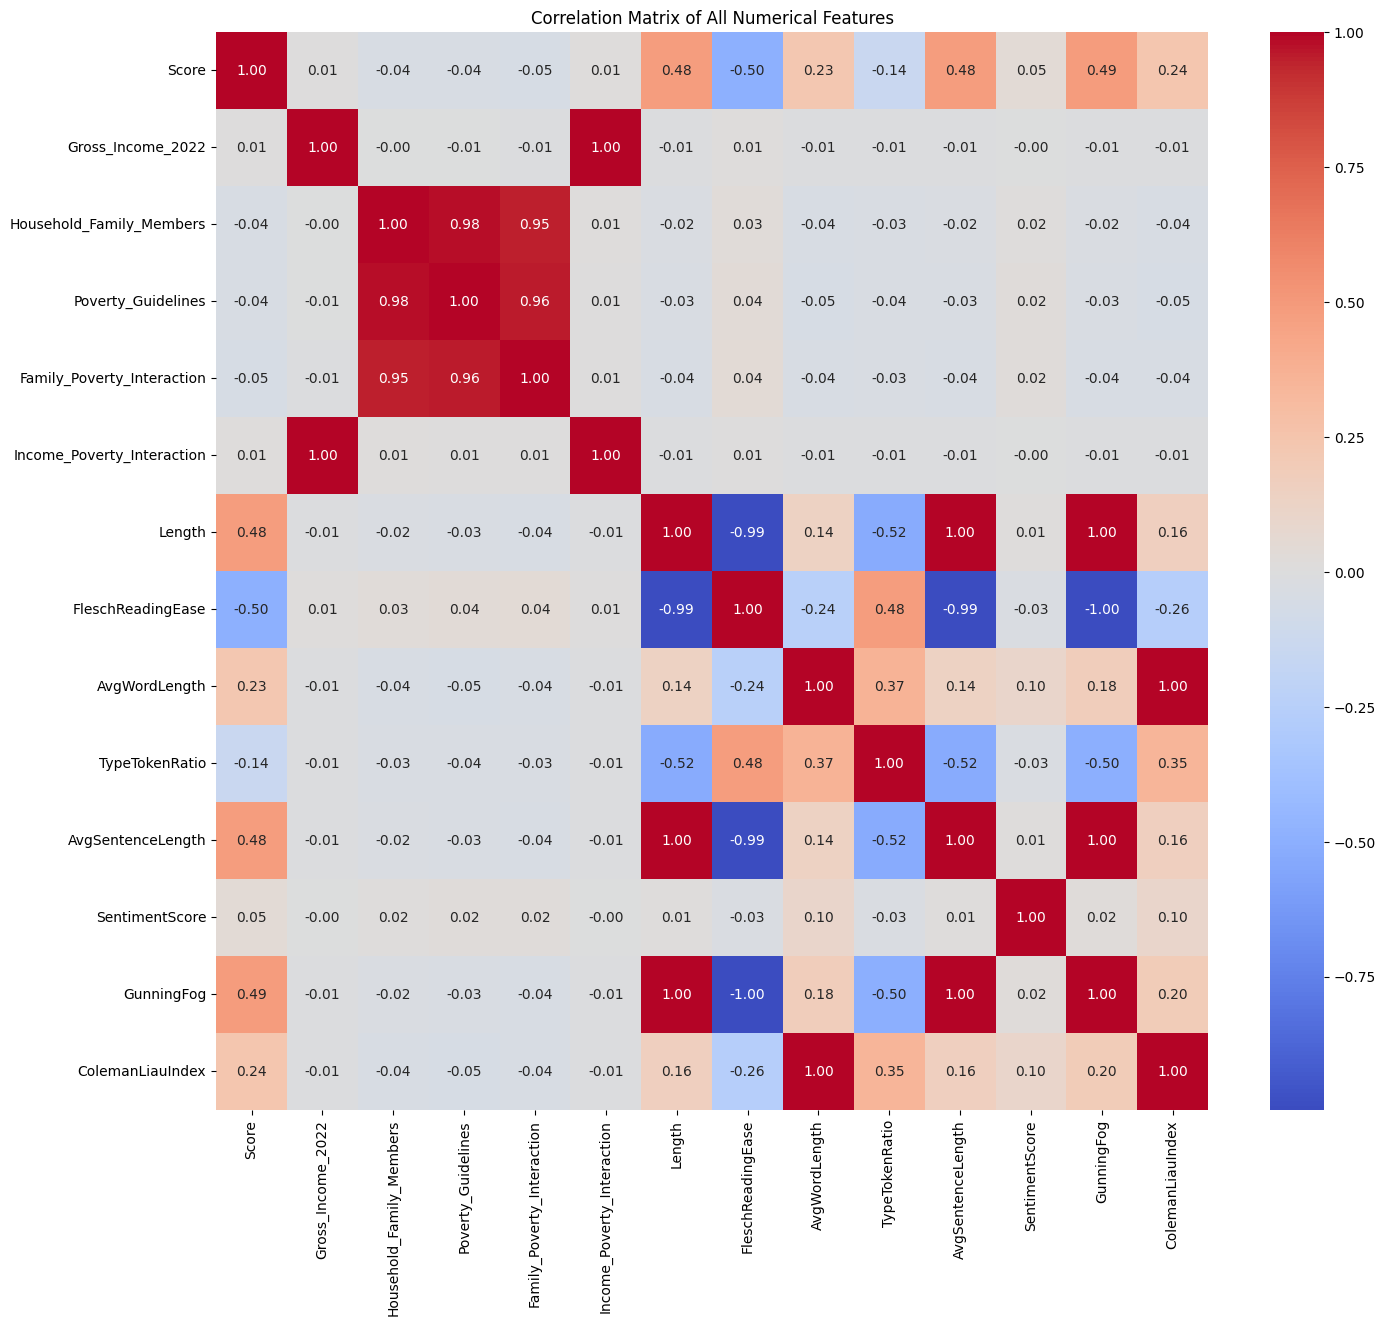

In [ ]:
# Calculate the correlation matrix
corr = combined_df[['Score', 'Gross_Income_2022', 'Household_Family_Members', 'Poverty_Guidelines',
                    'Family_Poverty_Interaction', 'Income_Poverty_Interaction','Length',
                    'FleschReadingEase', 'AvgWordLength', 'TypeTokenRatio', 'AvgSentenceLength',
                    'SentimentScore', 'GunningFog', 'ColemanLiauIndex']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of All Numerical Features')
plt.show()

In [ ]:
# Let's do some initial sentiment analysis.
print("Sentiment Score Statistics:")
print(combined_df['SentimentScore'].describe())

Sentiment Score Statistics:
count    12574.00000
mean         0.92156
std          0.30565
min         -0.99920
25%          0.98260
50%          0.99400
75%          0.99750
max          0.99980
Name: SentimentScore, dtype: float64


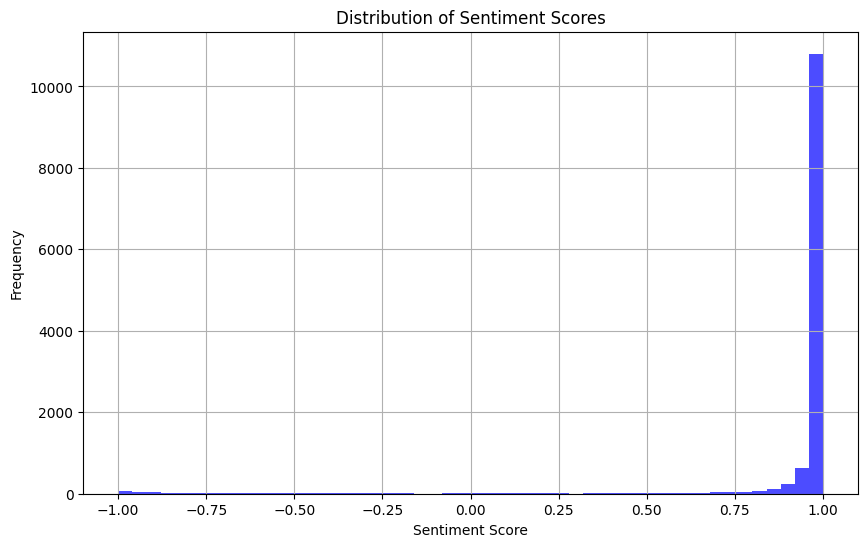

In [ ]:
# Plot a histogram of the sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(combined_df['SentimentScore'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Correlation between Sentiment Score and Essay Score:
                SentimentScore     Score
SentimentScore        1.000000  0.046095
Score                 0.046095  1.000000


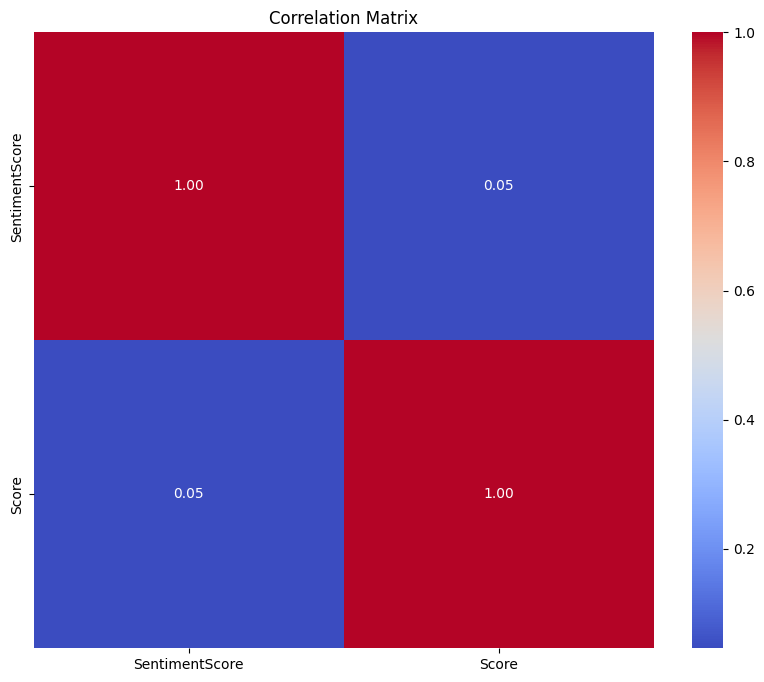

In [ ]:
# Correlation analysis with sentiment scores
print("Correlation between Sentiment Score and Essay Score:")
print(combined_df[['SentimentScore', 'Score']].corr())

# Visualize the correlation

plt.figure(figsize=(10, 8))
sns.heatmap(combined_df[['SentimentScore', 'Score']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


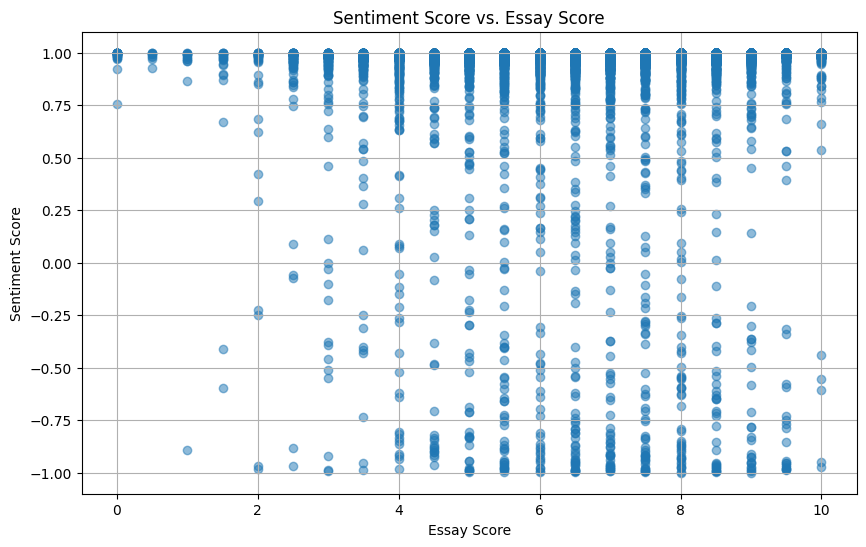

In [ ]:
# View a direct visual relationship between sentiment scores and essay scores
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['Score'], combined_df['SentimentScore'], alpha=0.5)
plt.title('Sentiment Score vs. Essay Score')
plt.xlabel('Essay Score')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()


In [ ]:
# Topic Modeling & Text Vectorization for LDA - I will use CountVectorizer from scikit-learn to convert my text data into a document-term matrix

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=1000)  # Limit number of features to keep top 1000, assuming English stop words

# Fit and transform the cleaned essays
dtm = vectorizer.fit_transform(combined_df['Essay'])

n_topics = 4 # Number of topics

# Initialize and fit the LDA model
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='online')
lda.fit(dtm)

# Assigning & Viewing Topics
# Get the topics for each document
topic_results = lda.transform(dtm)

# Assign the topic with the highest probability to each document
combined_df['Dominant_Topic'] = topic_results.argmax(axis=1)

# Let's take a look at the topics and their top words
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

feature_names = vectorizer.get_feature_names_out()  # Updated method for scikit-learn 1.0+
display_topics(lda, feature_names, 10)


Topic 0:
community support experiences sense journey cultural communities understanding life challenges
Topic 1:
people asian family culture american like identity school community life
Topic 2:
success college goals want life work goal help need achieve
Topic 3:
leader leadership team school students club skills year good time


Topic 0:


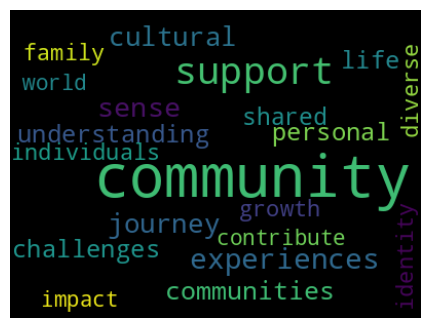

Topic 1:


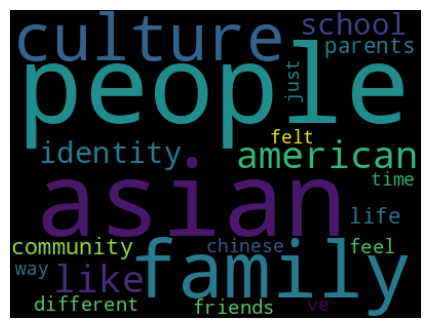

Topic 2:


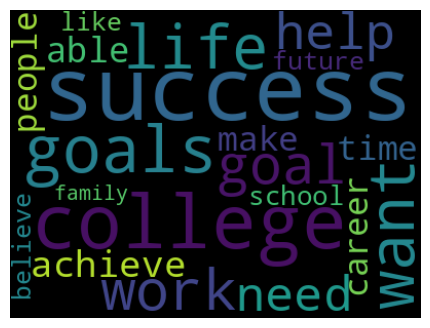

Topic 3:


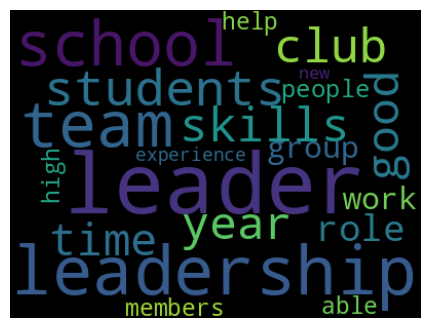

In [ ]:
# Let's visualize this in a word cloud format
def plot_word_clouds(model, feature_names, num_topics):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        freqs = {feature_names[i]: topic[i] for i in topic.argsort()[:-20 - 1:-1]}
        wc = WordCloud(width=400, height=300, max_words=20).generate_from_frequencies(freqs)
        plt.figure(figsize=(6, 4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

plot_word_clouds(lda, feature_names, n_topics)

In [ ]:
# View the count/distribution of 'dominant_topic'
topic_counts = combined_df['Dominant_Topic'].value_counts()
print(topic_counts)


Dominant_Topic
1    4536
2    3282
3    3008
0    1748
Name: count, dtype: int64


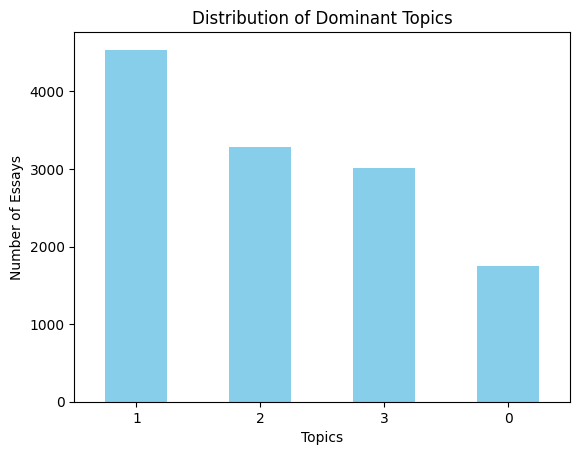

In [ ]:
# Plotting the distribution of 'dominant_topic' using a bar chart
topic_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topics')
plt.ylabel('Number of Essays')
plt.xticks(rotation=0)  # Rotates the labels on the x-axis so they show vertically
plt.show()


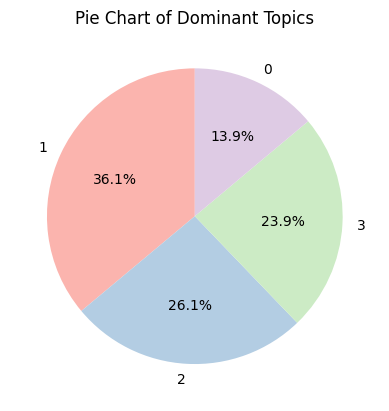

In [ ]:
# Pie chart of topic distribution
topic_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Pie Chart of Dominant Topics')
plt.ylabel('')  # Remove the y-label as it's usually 'dominant_topic' which isn't necessary here
plt.show()


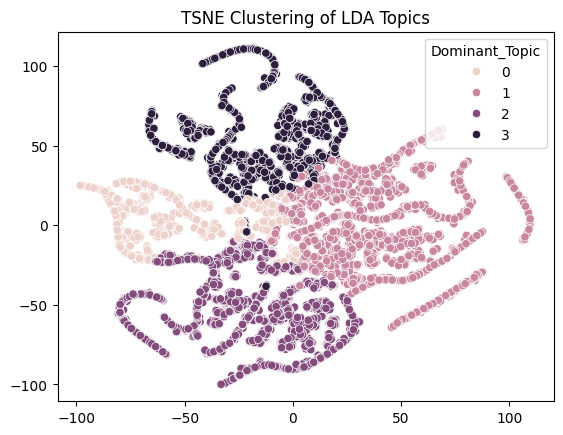

In [ ]:
# Cluster Analysis
# Let's perform cluster analysis on the document-topic probabilities to see how documents are grouped by topics.
# This can aid in understanding the distribution and separation of topics.

# TSNE for dimensionality reduction
topic_weights = lda.transform(dtm)
tsne = TSNE(n_components=2, random_state=42)
tsne_lda = tsne.fit_transform(topic_weights)

# Plot the Topic Clusters using seaborn
sns.scatterplot(x=tsne_lda[:, 0], y=tsne_lda[:, 1], hue=combined_df['Dominant_Topic'])
plt.title('TSNE Clustering of LDA Topics')
plt.show()

In [ ]:
# Topic coherence measures the degree of semantic similarity between high scoring words in the topic.
# Let's use Gensim's Coherence Model to evaluate how interpretable the topics are...
# Convert sparse matrix of counts to a gensim corpus
corpus = [dtm[i].toarray()[0] for i in range(dtm.shape[0])]
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
lda_gensim = LdaModel(corpus=[list(zip(range(len(doc)), doc)) for doc in corpus],
                      id2word=id2word,
                      num_topics=n_topics,
                      passes=10)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_gensim, texts=[doc.split() for doc in combined_df['Essay']],
                                     dictionary=Dictionary([doc.split() for doc in combined_df['Essay']]),
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Coherence Score:  0.2649195042800304


In [ ]:
# Advanced preprocessing to see if it helps our coherence score: Lemmatizing
lemmatizer = WordNetLemmatizer()
processed_docs = [[lemmatizer.lemmatize(word) for word in word_tokenize(doc)] for doc in combined_df['Essay']]

# Filter extremes in dictionary
# Ensure dictionary creation and filtering are consistent
dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)  # Adjust
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Adjust model parameters
lda_gensim = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, passes=10)

coherence_model_lda = CoherenceModel(model=lda_gensim, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Updated Coherence Score: ', coherence_lda)



 Updated Coherence Score:  0.44069699820490216


In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12574 entries, 0 to 12573
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Essay                                  12574 non-null  object 
 1   Score                                  12574 non-null  float64
 2   Gross_Income_2022                      12574 non-null  float64
 3   Household_Family_Members               12574 non-null  int64  
 4   Poverty_Guidelines                     12574 non-null  int64  
 5   Gender                                 12574 non-null  object 
 6   Region                                 12574 non-null  object 
 7   Specific_AA_Ethnicity                  12574 non-null  object 
 8   Specific_NHPI_Ethnicity                12574 non-null  object 
 9   Siblings_College                       12574 non-null  object 
 10  Parent1_Edu                            12574 non-null  object 
 11  Pa

In [ ]:
combined_df.describe()


,Score,Gross_Income_2022,Household_Family_Members,Poverty_Guidelines,Family_Poverty_Interaction,Income_Poverty_Interaction,Length,FleschReadingEase,AvgWordLength,TypeTokenRatio,AvgSentenceLength,SentimentScore,GunningFog,ColemanLiauIndex,Dominant_Topic
count,12574.000000,1.257400e+04,12574.000000,12574.000000,1.257400e+04,1.257400e+04,12574.000000,12574.000000,12574.000000,12574.000000,12574.000000,12574.00000,12574.000000,12574.000000,12574.000000
mean,6.827183,8.913552e+04,4.186337,32942.180690,1.531445e+05,2.852468e+09,383.875139,-309.400296,4.593024,0.517636,383.931446,0.92156,157.152287,10.810991,1.600445
std,1.699708,1.459291e+06,1.655688,9389.063494,1.125739e+05,3.769973e+10,112.951548,116.471280,0.450329,0.058112,112.969377,0.30565,45.314912,2.624517,0.998234
min,0.000000,0.000000e+00,1.000000,15060.000000,1.506000e+04,0.000000e+00,41.000000,-490.510000,3.414365,0.118012,41.000000,-0.99920,20.300000,3.680000,0.000000
25%,6.000000,2.700000e+04,3.000000,25820.000000,7.746000e+04,7.800000e+08,297.000000,-416.070000,4.259501,0.477778,297.000000,0.98260,122.567500,8.850000,1.000000
50%,7.000000,5.155500e+04,4.000000,31200.000000,1.248000e+05,1.704120e+09,412.000000,-338.590000,4.516661,0.514742,412.000000,0.99400,168.495000,10.360000,2.000000
75%,8.000000,9.154800e+04,5.000000,36580.000000,1.829000e+05,3.113140e+09,491.000000,-221.190000,4.868790,0.554656,491.000000,0.99750,200.017500,12.427500,2.000000
max,10.000000,9.414800e+07,15.000000,103970.000000,1.559550e+06,2.430901e+12,545.000000,46.780000,6.453125,0.833333,545.000000,0.99980,225.120000,21.610000,3.000000


In [ ]:
# Using a pipeline for Text Vectorization & Model Building

X = combined_df['Essay']  # my text data
y = combined_df['Score']  # my target variable

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a pipeline
base_linear_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, min_df=5, max_df=0.9, stop_words='english')),
    ('regressor', LinearRegression())
])

# Training the model
base_linear_pipeline.fit(X_train, y_train)

# Making predictions on both train and test sets
y_train_pred = base_linear_pipeline.predict(X_train)
y_test_pred = base_linear_pipeline.predict(X_test)

# Evaluating the model on the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluating the model on the testing set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print('Baseline Linear Regression Metrics:')
print(f"Training MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")


Baseline Linear Regression Metrics:
Training MSE: 0.9853395813414426, RMSE: 0.9926427259298497, R²: 0.6567021833346034
Testing MSE: 4.321159151751292, RMSE: 2.078739798953032, R²: -0.4584282481175532


In [ ]:
# Using a pipeline for Text Vectorization & Model Building - add the additional features

# Categorize features
numerical_features = ['Gross_Income_2022', 'Household_Family_Members', 'Poverty_Guidelines',
                      'Family_Poverty_Interaction', 'Income_Poverty_Interaction', 'Length',
                      'FleschReadingEase', 'AvgWordLength', 'TypeTokenRatio',
                      'AvgSentenceLength', 'SentimentScore', 'GunningFog', 'ColemanLiauIndex']

categorical_features = ['Gender', 'Region', 'Specific_AA_Ethnicity', 'Specific_NHPI_Ethnicity',
                        'Siblings_College', 'Parent1_Edu', 'Parent2_Edu', 'First-Gen',
                        'First-In-Family', 'Current_School_Year', 'Participation_College_Access_Programs',
                        'Enrolled_Undergrad_Student', 'Institution_Type', 'Type_of_funded_institution',
                        'AANAPISI', 'Area_of_Study', 'Financially_Independent']

# Define the feature set and target variable
X = combined_df.drop('Score', axis=1)
y = combined_df['Score']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a ColumnTransformer to combine the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('txt', TfidfVectorizer(stop_words='english'), 'Essay')
    ])

# Creating a pipeline
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Training the model
linear_pipeline.fit(X_train, y_train)

# Making predictions on both train and test sets
y_train_pred = linear_pipeline.predict(X_train)
y_test_pred = linear_pipeline.predict(X_test)

# Evaluating the model on the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluating the model on the testing set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print('Linear Regression Metrics with encoded features:')
print(f"Training MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# Linear Regression model with encoded features
#Training MSE: 0.018584493144041134, RMSE: 0.13632495422350646, R²: 0.9935250587300101
#Testing MSE: 5.934810186232986, RMSE: 2.4361465855389297, R²: -1.00304930201658

Linear Regression Metrics with encoded features:
Training MSE: 0.018584493144041134, RMSE: 0.13632495422350646, R²: 0.9935250587300101
Testing MSE: 5.934810186232986, RMSE: 2.4361465855389297, R²: -1.00304930201658


In [ ]:
# The linear model is overfitting... let's apply regularization: Ridge

# Re-create the pipeline with Ridge regression
linear_ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))  # alpha is a tuning parameter
])

# Training the model
linear_ridge_pipeline.fit(X_train, y_train)

# Making predictions
y_train_pred = linear_ridge_pipeline.predict(X_train)
y_test_pred = linear_ridge_pipeline.predict(X_test)

# Evaluate on training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate on testing set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print('Linear Regression Metrics with Ridge regularization:')
print(f"Training MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# These scores are better with Ridge regularization!
#Training MSE: 0.9080300852985816, RMSE: 0.9529061261732876, R²: 0.6836372437965859
#Testing MSE: 2.141718254011583, RMSE: 1.463461053124265, R²: 0.27715173372089785


Linear Regression Metrics with Ridge regularization:
Training MSE: 0.908030089913305, RMSE: 0.9529061285946822, R²: 0.6836372421887904
Testing MSE: 2.1417001801572644, RMSE: 1.4634548780735483, R²: 0.27715783380163184


In [ ]:
# Let's try Lasso to see if this would improve our scores.

# Adjust the pipeline to use Lasso to see if this helps...
linear_lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.001, random_state=42))  # alpha is a tuning parameter
])

# Training the model with Lasso
linear_lasso_pipeline.fit(X_train, y_train)

# Making predictions again
y_train_pred = linear_lasso_pipeline.predict(X_train)
y_test_pred = linear_lasso_pipeline.predict(X_test)

# Evaluating the model again
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print('Linear Regression Metrics with Lasso regularization:')
print(f"Training MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# Our scores on train got worse, but we see that the model is not overfitting.
# Training MSE: 1.983215173014008, RMSE: 1.4082667265166808, R²: 0.30903675061291225
# Testing MSE: 2.1350682749139214, RMSE: 1.4611872826280419, R²: 0.2793961586598612

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1029.04760654665, tolerance: 2.887152311362958
  model = cd_fast.sparse_enet_coordinate_descent(


Linear Regression Metrics with Lasso regularization:
Training MSE: 1.9832151730140082, RMSE: 1.4082667265166808, R²: 0.30903675061291214
Testing MSE: 2.135068274913922, RMSE: 1.461187282628042, R²: 0.2793961586598611


In [ ]:
# Let's see if ElasticNet will help.

# Create a pipeline with ElasticNet
linear_elastic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))  # alpha and l1_ratio can be tuned
])

# Fit the model
linear_elastic_pipeline.fit(X_train, y_train)

# Making predictions
y_train_pred = linear_elastic_pipeline.predict(X_train)
y_test_pred = linear_elastic_pipeline.predict(X_test)

# Evaluating the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print('Linear Regression Metrics with ElasicNet regularization:')
print(f"Training MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# Not much better.
#Training MSE: 2.1127422783554524, RMSE: 1.4535275292733372, R²: 0.2639087832555367
#Testing MSE: 2.2200171701393, RMSE: 1.4899722044854729, R²: 0.2507251784686181

Linear Regression Metrics with ElasicNet regularization:
Training MSE: 2.1127422783554524, RMSE: 1.4535275292733372, R²: 0.2639087832555367
Testing MSE: 2.2200171701393, RMSE: 1.4899722044854729, R²: 0.2507251784686181


In [ ]:
# Check for feature importance
# Accessing the linear regression model from the pipeline
linear_reg_model = linear_elastic_pipeline.named_steps['regressor']

# Accessing feature names after transformation
feature_names = (
    list(linear_elastic_pipeline.named_steps['preprocessor']
         .transformers_[0][1]  # StandardScaler for numerical features
         .get_feature_names_out(numerical_features))
    + list(linear_elastic_pipeline.named_steps['preprocessor']
           .named_transformers_['cat']  # OneHotEncoder for categorical features
           .get_feature_names_out(categorical_features))
    + list(linear_elastic_pipeline.named_steps['preprocessor']
           .named_transformers_['txt']  # TfidfVectorizer for text data
           .get_feature_names_out())
)

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': linear_reg_model.coef_
})

# Sort the features by the absolute values of their coefficients
feature_importances = feature_importances.sort_values(by='Coefficient', key=abs, ascending=False)

# Display the DataFrame
print(feature_importances.head(20))

                          Feature  Coefficient
6               FleschReadingEase    -0.243679
11                     GunningFog     0.190288
5                          Length     0.153267
9               AvgSentenceLength     0.151503
12               ColemanLiauIndex     0.137213
19                   Gender_Woman     0.072020
7                   AvgWordLength     0.061001
8                  TypeTokenRatio     0.014287
3      Family_Poverty_Interaction    -0.006617
10                 SentimentScore     0.002880
23461                       plead    -0.000000
23462                     pleaded     0.000000
23463                    pleading     0.000000
23460                        plea     0.000000
23459                       plaza     0.000000
23458                  playwright    -0.000000
23456                  playstyles    -0.000000
23464                       pleas    -0.000000
23465                    pleasant    -0.000000
23466                  pleasantly     0.000000


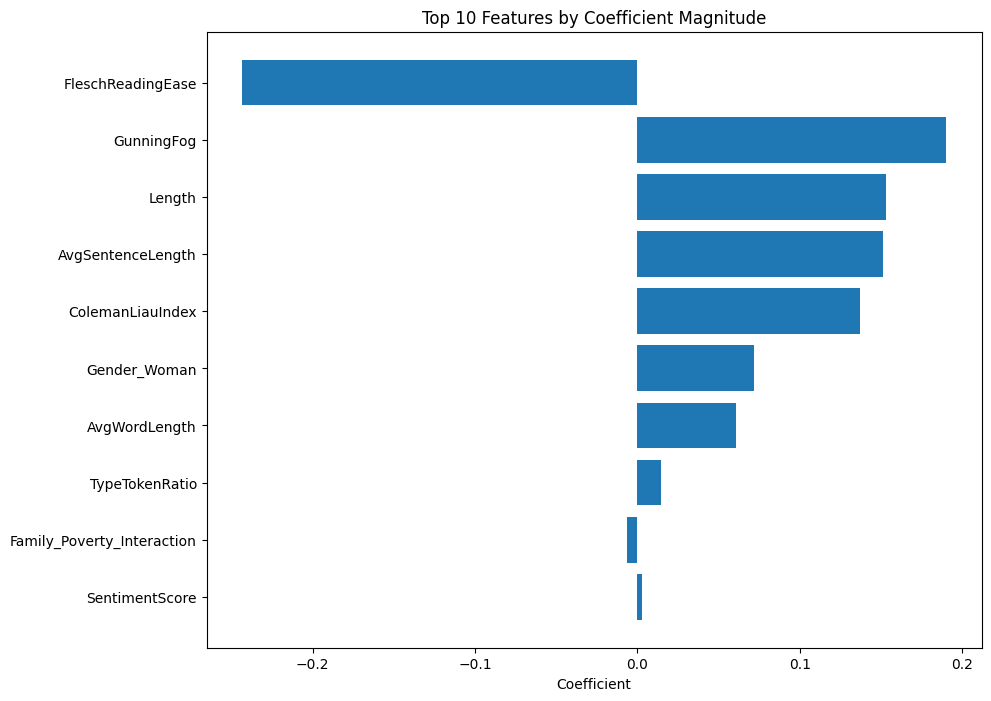

In [ ]:
# Let's visualize the top 10 features by coefficient magnitude
top_features = feature_importances.head(10)

plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Top 10 Features by Coefficient Magnitude')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest bar on top
plt.show()

In [ ]:
# Let's try a more complex model next, an ensemble method: Random Forest

# Creating a pipeline with Random Forest Regressor
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
     ('rf', RandomForestRegressor(n_estimators=50, random_state=42))
])

# Training the model
rf_pipeline.fit(X_train, y_train)

# Making predictions on both train and test sets
y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)

# Evaluating the model on the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluating the model on the testing set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Print training and testing metrics
print("Random Forest Metrics:")
print(f"Training MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# RF Scores without Randomized Search
# Training MSE: 0.30727772020964916, RMSE: 0.5543263661505279, R²: 0.8929427250712064
# Testing MSE: 2.0944790651916168, RMSE: 1.447231517481435, R²: 0.29309536481008736

Random Forest Metrics:
Training MSE: 0.30727772020964916, RMSE: 0.5543263661505279, R²: 0.8929427250712064
Testing MSE: 2.0944790651916168, RMSE: 1.447231517481435, R²: 0.29309536481008736


In [ ]:
# Let's tune our parameters to get a better score
# Instead of exhaustively searching through all possible outcomes like Grid Search, I'll opt for Random Search
# to randomly sample a subset of parameter combinations.

# Parameter grid for Randomized Search
param_distributions = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_features': [10, 15, 25],
}

# Adjust the pipeline to skip preprocessing
rf_tuned_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42))
])

# Setup RandomizedSearchCV with corrected parameter names
random_search = RandomizedSearchCV(estimator=rf_tuned_pipeline, param_distributions=param_distributions, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Using the best estimator found by RandomizedSearchCV for predictions
best_model_rf = random_search.best_estimator_

# Making predictions on both the training and testing sets using the best estimator
y_train_pred = best_model_rf.predict(X_train)
y_test_pred = best_model_rf.predict(X_test)

# Evaluating the model on the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluating the model on the testing set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Print training and testing metrics
print("Random Forest Metrics with Randomized Search:")
print(f"Training MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# RF Scores with  Randomized Search
# Training MSE: 2.3360624006268704, RMSE: 1.5284182675651552, R²: 0.1861028046416917
# Testing MSE: 2.6848717955430152, RMSE: 1.6385578401579284, R²: 0.09383275836830374
# Best parameters found:  {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__max_features': 25, 'rf__max_depth': 20}

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__max_features': 25, 'rf__max_depth': 20}
Random Forest Metrics with Randomized Search:
Training MSE: 2.3360624006268704, RMSE: 1.5284182675651552, R²: 0.1861028046416917
Testing MSE: 2.6848717955430152, RMSE: 1.6385578401579284, R²: 0.09383275836830374


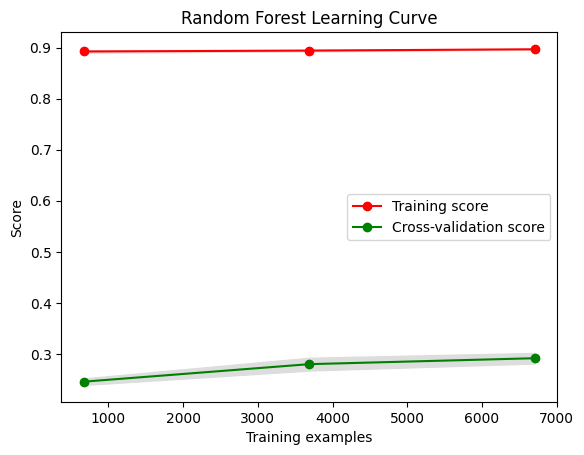

In [145]:
# Plot learning curves for both training and validation scores
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_tuned_pipeline, X=X_train, y=y_train, cv=3, train_sizes=np.linspace(.1, 1.0, 3)
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Same for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Random Forest Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [146]:
# Let's try even more powerful ensemble methods: Gradient Boosting and XGBoost. Let's start with Gradient Boosting first.

# Gradient Boosting pipeline with early stopping using part of the training data as internal validation
gbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gbr', GradientBoostingRegressor(
        n_estimators=100,  # Start with a higher number of estimators
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        validation_fraction=0.2,  # Use 20% of the training data for early stopping validation
        n_iter_no_change=10,  # Stop if no improvement for 10 iterations
        tol=0.01  # Tolerance for the early stopping
    ))
])

# Training the model
gbm_pipeline.fit(X_train, y_train)

# Making predictions
y_train_pred = gbm_pipeline.predict(X_train)
y_test_pred = gbm_pipeline.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print("Gradient Boosting Metrics:")
print(f"Training MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# GBM Scores without Randomized Search
# Training MSE: 1.8799757953963925, RMSE: 1.3711220935410502, R²: 0.34500592672351893
# Testing MSE: 2.13869220953703, RMSE: 1.462426821942565, R²: 0.27817304966570844

Gradient Boosting Metrics:
Training MSE: 1.8799757953963925, RMSE: 1.3711220935410502, R²: 0.34500592672351893
Testing MSE: 2.13869220953703, RMSE: 1.462426821942565, R²: 0.27817304966570844


In [147]:
# Let's also finetune parameters for Gradient Boosting

# Parameter grid for Randomized Search
param_distributions = {
    'gbr__n_estimators': [50, 100, 200],
    'gbr__learning_rate': [0.01, 0.1, 0.2, 0.5],
    'gbr__max_depth': [3, 5, 10],
    'gbr__min_samples_split': [2, 5, 10],
    'gbr__max_features': [10, 15, 25],
}

gbm_tuned_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('gbr', GradientBoostingRegressor(random_state=42))
])

# Setup RandomizedSearchCV with corrected parameter names
random_search = RandomizedSearchCV(estimator=gbm_tuned_pipeline, param_distributions=param_distributions, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Using the best estimator found by RandomizedSearchCV for predictions
best_model_gbm = random_search.best_estimator_

# Making predictions on both the training and testing sets using the best estimator
y_train_pred = best_model_gbm.predict(X_train)
y_test_pred = best_model_gbm.predict(X_test)

# Evaluating the model on the training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluating the model on the testing set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Print training and testing metrics
print("Gradient Boosting Metrics with Randomized Search:")
print(f"Training MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# GBM Scores with Randomized Search
# Training MSE: 1.4338970704295084, RMSE: 1.1974544126727782, R²: 0.5004222473929203
# Testing MSE: 2.292062500033063, RMSE: 1.5139559108616945, R²: 0.22640926216652413
# Best parameters found: {'gbr__n_estimators': 200, 'gbr__min_samples_split': 2, 'gbr__max_features': 25, 'gbr__max_depth': 5, 'gbr__learning_rate': 0.2}

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'gbr__n_estimators': 200, 'gbr__min_samples_split': 2, 'gbr__max_features': 25, 'gbr__max_depth': 5, 'gbr__learning_rate': 0.2}
Gradient Boosting Metrics with Randomized Search:
Training MSE: 1.4338970704295084, RMSE: 1.1974544126727782, R²: 0.5004222473929203
Testing MSE: 2.292062500033063, RMSE: 1.5139559108616945, R²: 0.22640926216652413


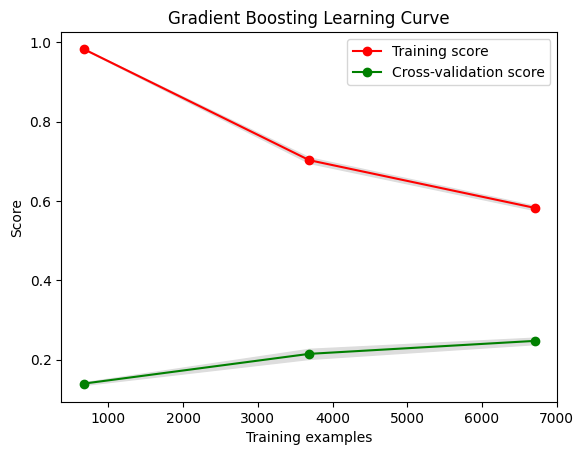

In [148]:
# Plot learning curves for both training and validation scores
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model_gbm,  # Use the best model found by RandomizedSearchCV
    X=X_train,
    y=y_train,
    cv=3,
    train_sizes=np.linspace(.1, 1.0, 3),  # Adjust train sizes as needed
    n_jobs=-1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Same for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Gradient Boosting Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [152]:
# XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42))
])

# Training the model
xgb_pipeline.fit(X_train, y_train)

# Making predictions
y_train_pred = xgb_pipeline.predict(X_train)
y_test_pred = xgb_pipeline.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print("XGBoost Metrics:")
print(f"Training MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# XGB Scores
# Training MSE: 1.5430233020009945, RMSE: 1.242184890425332, R²: 0.46240205846636584
# Testing MSE: 2.103302783491123, RMSE: 1.450276795474272, R²: 0.2901172842605163

XGBoost Metrics:
Training MSE: 1.5430233020009945, RMSE: 1.242184890425332, R²: 0.46240205846636584
Testing MSE: 2.103302783491123, RMSE: 1.450276795474272, R²: 0.2901172842605163


In [160]:
# Let's also finetune parameters for XGBoost

# Parameter grid for XGBoost
param_distributions = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 7, 9],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", random_search.best_params_)

# Using the best estimator found by RandomizedSearchCV for predictions
best_model_xgb = random_search.best_estimator_
y_train_pred = best_model_xgb.predict(X_train)
y_test_pred = best_model_xgb.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Print training and testing metrics
print("XGBoost Metrics with Randomized Search:")
print(f"Training MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# XGB Scores with Randomized Search
# Training MSE: 1.4612499154665586, RMSE: 1.2088217054084356, R²: 0.4908923633218648
# Testing MSE: 2.09975514029484, RMSE: 1.4490531875313755, R²: 0.29131464424426146
# Best parameters found:  {'xgb__subsample': 0.6, 'xgb__n_estimators': 150, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.05, 'xgb__colsample_bytree': 0.8}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'xgb__subsample': 0.6, 'xgb__n_estimators': 150, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.05, 'xgb__colsample_bytree': 0.8}
XGBoost Metrics with Randomized Search:
Training MSE: 1.4612499154665586, RMSE: 1.2088217054084356, R²: 0.4908923633218648
Testing MSE: 2.09975514029484, RMSE: 1.4490531875313755, R²: 0.29131464424426146


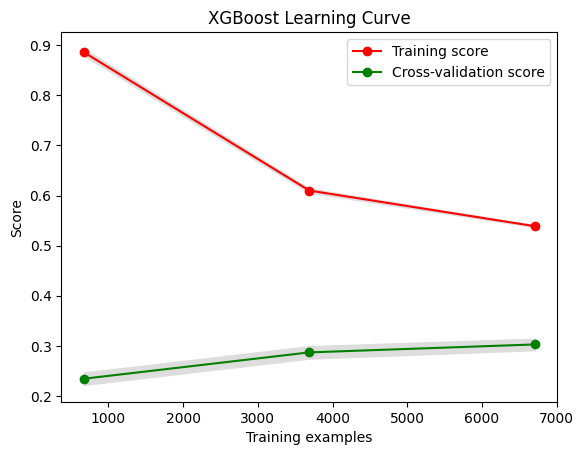

In [161]:
# Plot learning curves for both training and validation scores
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model_xgb,  # Use the best model found by RandomizedSearchCV
    X=X_train,
    y=y_train,
    cv=3,
    train_sizes=np.linspace(.1, 1.0, 3),  # Adjust train sizes as needed
    n_jobs=-1
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Same for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("XGBoost Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [162]:
# Saving all the pipelines
dump(rf_pipeline, 'rf_pipeline.joblib')
dump(rf_tuned_pipeline, 'rf_tuned_pipeline.joblib')
dump(gbm_pipeline, 'gbm_pipeline.joblib')
dump(gbm_tuned_pipeline, 'gbm_tuned_pipeline.joblib')
dump(xgb_pipeline, 'xgb_pipeline.joblib')

# To load the pipelines later on...
# rf_pipeline = load('rf_pipeline.joblib')
# rf_tuned_pipeline = load('rf_tuned_pipeline.joblib')
# gbm_pipeline = load('gbm_pipeline.joblib')
# gbm_tuned_pipeline = load('gbm_tuned_pipeline.joblib')
# xgb_pipeline = load('xgb_pipeline.joblib')

['xgb_pipeline.joblib']

In [163]:
# Let's try advanced text analysis with deep learning methods next...
# Implementing LSTM with TensorFlow/Keras

# Prepare data
essays = combined_df['Essay']
scores = combined_df['Score']

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(essays)
sequences = tokenizer.texts_to_sequences(essays)
padded_sequences = pad_sequences(sequences, maxlen=500)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, scores, test_size=0.2, random_state=42)

# Build the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=50, input_length=500),  # Reduced output_dim
    LSTM(32),  # Reduced number of units
    Dropout(0.5),
    Dense(1, activation='linear')  # Use 'linear' for regression tasks
])

lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
lstm_model.summary()

# Callbacks to improve training efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model with callbacks
history = lstm_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           250000    
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 260657 (1018.19 KB)
Trainable params: 260657 (1018.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
158/158 [==============================] - 111s 674ms/step - loss: 12.1574 - mean_squared_error: 12.1574 - val_loss: 3.0348 - val_mean_

In [164]:
# Making predictions
y_train_pred = lstm_model.predict(X_train)
y_test_pred = lstm_model.predict(X_test)

# Round predictions to the nearest half integer
y_train_pred = np.round(y_train_pred * 2) / 2
y_test_pred = np.round(y_test_pred * 2) / 2

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Output results
print("LSTM Model Evaluation:")
print(f"Training - MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing - MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# Display actual vs predicted for a sample, for intuitive understanding
print("\nSample Predictions:")
for actual, predicted in zip(y_test[:10], y_test_pred[:10]):
    print(f"Actual: {actual}, Predicted: {predicted[0]}")

# LSTM Scores
# Training - MSE: 2.7799234516353515, RMSE: 1.667310244566185, R²: 0.03145913397276945
# Testing - MSE: 2.994135188866799, RMSE: 1.7303569541764494, R²: -0.010546287413728539

79/79 [==============================] - 6s 74ms/step
LSTM Model Evaluation:
Training - MSE: 2.873073864201213, RMSE: 1.6950144141573584, R²: -0.0009949903320776166
Testing - MSE: 3.008747514910537, RMSE: 1.7345741595303836, R²: -0.015478072688115851

Sample Predictions:
Actual: 7.0, Predicted: 6.5
Actual: 8.5, Predicted: 6.5
Actual: 7.0, Predicted: 6.5
Actual: 6.5, Predicted: 7.0
Actual: 9.0, Predicted: 6.5
Actual: 5.0, Predicted: 6.5
Actual: 4.5, Predicted: 6.5
Actual: 4.0, Predicted: 6.5
Actual: 7.0, Predicted: 6.5
Actual: 5.5, Predicted: 6.5


In [165]:
# Saving the model
model_path = '/content/drive/My Drive/lstm_model.keras'
lstm_model.save(model_path)

# To reload from Google Drive:
# loaded_lstm_model = load_model(model_path)

In [166]:
# Let's try a bidirectional LSTM, which may be more useful because they can process data in both directions

# Build the Bidirectional LSTM model
bi_lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=50, input_length=500),
    Bidirectional(LSTM(32)),  # Using a Bidirectional wrapper around the LSTM layer
    Dropout(0.5),
    Dense(1, activation='linear')  # Use 'linear' for regression tasks
])

bi_lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
bi_lstm_model.summary()

# Callbacks to improve training efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model with callbacks
history = bi_lstm_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 50)           250000    
                                                                 
 bidirectional (Bidirection  (None, 64)                21248     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 271313 (1.03 MB)
Trainable params: 271313 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
158/158 [==============================] - 180s 1s/step - loss: 9.7285 - 

In [167]:
# Making predictions
y_train_pred = bi_lstm_model.predict(X_train)
y_test_pred = bi_lstm_model.predict(X_test)

# Round predictions to the nearest half integer
y_train_pred = np.round(y_train_pred * 2) / 2
y_test_pred = np.round(y_test_pred * 2) / 2

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Output results
print("Bidirectional LSTM Model Evaluation:")
print(f"Training - MSE: {train_mse}, RMSE: {train_rmse}, R²: {train_r2}")
print(f"Testing - MSE: {test_mse}, RMSE: {test_rmse}, R²: {test_r2}")

# Display actual vs predicted for a sample, for intuitive understanding
print("\nSample Predictions:")
for actual, predicted in zip(y_test[:10], y_test_pred[:10]):
    print(f"Actual: {actual}, Predicted: {predicted[0]}")

# Bidirectional LSTM Scores
# Training - MSE: 2.7197534546177553, RMSE: 1.649167503505255, R²: 0.052422697191028544
# Testing - MSE: 2.986779324055666, RMSE: 1.72823011316655, R²: -0.008063619996690141

79/79 [==============================] - 11s 142ms/step
Bidirectional LSTM Model Evaluation:
Training - MSE: 2.7218908440202805, RMSE: 1.6498153969521197, R²: 0.05167801877848399
Testing - MSE: 2.992544731610338, RMSE: 1.7298973182273965, R²: -0.010009494458693258

Sample Predictions:
Actual: 7.0, Predicted: 6.5
Actual: 8.5, Predicted: 6.5
Actual: 7.0, Predicted: 7.0
Actual: 6.5, Predicted: 7.0
Actual: 9.0, Predicted: 7.0
Actual: 5.0, Predicted: 7.0
Actual: 4.5, Predicted: 6.5
Actual: 4.0, Predicted: 6.5
Actual: 7.0, Predicted: 7.0
Actual: 5.5, Predicted: 6.5


In [168]:
model_path = '/content/drive/My Drive/bi_lstm_model.keras'
bi_lstm_model.save(model_path)

# To reload from Google Drive:
# loaded_bi_lstm_model = load_model(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.GlorotUniform'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.Orthogonal'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.Zeros'>,

In [169]:
# Implementing DistilBERT for Essay Scoring

# Load the tokenizer and model
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)  # num_labels=1 for regression

# Prepare the essays and scores
essays = combined_df['Essay'].tolist()
scores = combined_df['Score'].values

inputs = distilbert_tokenizer(essays, max_length=512, truncation=True, padding="max_length", return_tensors="tf")
inputs = {key: tf.convert_to_tensor(value) for key, value in inputs.items()}

# Prepare TF dataset
dataset = tf.data.Dataset.from_tensor_slices((inputs, scores)).shuffle(len(essays)).batch(8)

# Determine the number of batches that fit within the training and test datasets
total_batches = len(dataset)
train_size = int(total_batches * 0.8)  # 80% for training
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Model compilation and training
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)
distilbert_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
history = distilbert_model.fit(train_dataset, epochs=3, validation_data=test_dataset)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1257/1257 [==============================] - 410s 289ms/step - loss: 3.4124 - mean_squared_error: 3.4124 - val_loss: 3.1058 - val_mean_squared_error: 3.1058
Epoch 2/3
1257/1257 [==============================] - 357s 284ms/step - loss: 3.1858 - mean_squared_error: 3.1858 - val_loss: 3.0704 - val_mean_squared_error: 3.0704
Epoch 3/3
1257/1257 [==============================] - 357s 284ms/step - loss: 3.1975 - mean_squared_error: 3.1975 - val_loss: 2.9295 - val_mean_squared_error: 2.9295


In [173]:
# Evaluate the model
train_mse = history.history['loss'][-1]  # Using the last loss value as training MSE
test_mse = history.history['val_loss'][-1]  # Using the last validation loss value as validation MSE

print('DistilBERT Model Evaluation:')
print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)

# DistilBERT Scores
# Training MSE: 3.289954662322998
# Testing MSE: 3.1849493980407715

DistilBERT Model Evaluation:
Training MSE: 3.1974802017211914
Testing MSE: 2.9294517040252686


In [174]:
distilbert_model.save_pretrained('/content/drive/My Drive/distilbert_model')
distilbert_tokenizer.save_pretrained('/content/drive/My Drive/distilbert_tokenizer')

# Once saved, I can load my model and tokenizer from the same paths:
# distilbert_tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/My Drive/distilbert_tokenizer')
# distilbert_model = TFDistilBertForSequenceClassification.from_pretrained('/content/drive/My Drive/distilbert_model')

('/content/drive/My Drive/distilbert_tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/distilbert_tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/distilbert_tokenizer/vocab.txt',
 '/content/drive/My Drive/distilbert_tokenizer/added_tokens.json')

In [175]:
! nvidia-smi

Thu May  2 02:12:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   70C    P0              33W /  72W |   8567MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--